In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [30]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
newest_date = session.query(Measurement.date).order_by(Measurement.id.desc()).first()
newest_date

('2017-08-23',)

Text(0, 0.5, 'Inches')

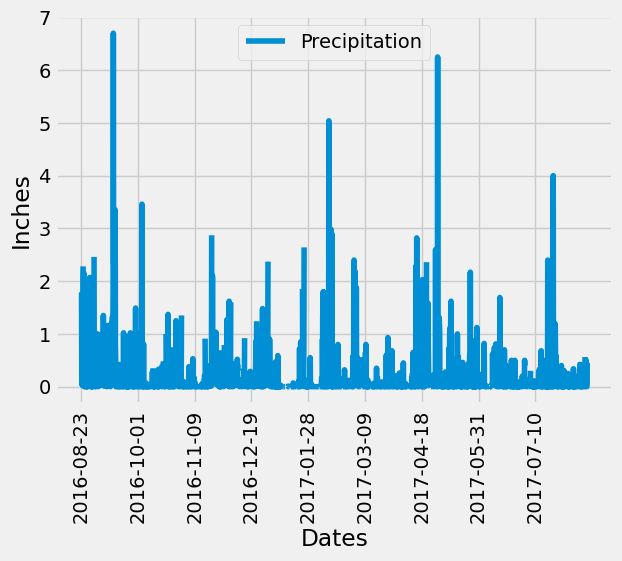

In [143]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_before = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve all the dates and precipitation scores for the last 12 months
prcp_last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before).all()

# Save the (all) query results as a Pandas DataFrame. Explicitly set the column names
dt_prcp_df = pd.DataFrame(prcp_last_12, columns =['Dates', 'Precipitation'])

# Sort the dataframe by date
sorted_dt_prcp_df = dt_prcp_df.sort_values(by='Dates',ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data into bar graph
sorted_dt_prcp_df.plot(x='Dates', y='Precipitation')

# Set x axis, tick locations, and y-label
x_axis = np.arange(len(sorted_dt_prcp_df))
tick_locations = plt.xticks(x_axis[::250], sorted_dt_prcp_df['Dates'].values[::250], rotation=90)
plt.ylabel("Inches")

In [117]:
# Use Pandas to calculate the summary statistics for the precipitation data
# mean, median, variance, standard deviation, and SEM of the tumor volume.
precipitation_mean = dt_prcp_df['Precipitation'].mean()
precipitation_median = dt_prcp_df['Precipitation'].median()
precipitation_min = dt_prcp_df['Precipitation'].min()
precipitation_stdev = dt_prcp_df['Precipitation'].std()
precipitation_count = dt_prcp_df['Precipitation'].count()

# Determine outliers using upper and lower bounds
quartiles = dt_prcp_df['Precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
midq = quartiles[0.50]

# Create Summary Statistics Data Frame
category_list = ["count", "mean", "median", "std", "25%", "50%", "75%", "min"]
prcp_list = [precipitation_count, precipitation_mean, precipitation_median, precipitation_stdev, lowerq, midq, upperq, precipitation_min]
prcp_sum_df = pd.DataFrame(
                            {"" : category_list ,
                             "Precipitation" : prcp_list})

prcp_sum_df

,,Precipitation
0,count,2021.000000
1,mean,0.177279
2,median,0.020000
3,std,0.461190
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,min,0.000000


In [118]:
# Better version
dt_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
station_count = len(session.query(Station.station).all())
station_count

9

In [100]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, 
   func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Create a list of each stations 'min_temp' 
min_temp = session.query(Measurement.station, 
   func.min(Measurement.tobs)).group_by(Measurement.station).all()

# Create a list of each stations 'max_temp' 
max_temp = session.query(Measurement.station, 
   func.max(Measurement.tobs)).group_by(Measurement.station).all()
max_temp

# Create a list of each stations 'avg_temp' (average temperature)
avg_temp = session.query(Measurement.station, 
   func.avg(Measurement.tobs)).group_by(Measurement.station).all()

# Create a dataframe from the 'min_temp' list
min_temp_df = pd.DataFrame(min_temp, columns=['station', 'min temperature'])

# Create a dataframe from the 'max_temp' list
max_temp_df = pd.DataFrame(max_temp, columns=['station', 'max temperature'])

# Create a dataframe from the 'avg_temp' list
avg_temp_df = pd.DataFrame(avg_temp, columns=['station', 'avg temperature'])

# Print the the lowest, highest, and average temperature for the 'most active station'
print(min_temp_df.loc[min_temp_df['station'] == 'USC00519281'])
print(max_temp_df.loc[max_temp_df['station'] == 'USC00519281'])
print(avg_temp_df.loc[avg_temp_df['station'] == 'USC00519281'])

       station  min temperature
6  USC00519281             54.0
       station  max temperature
6  USC00519281             85.0
       station  avg temperature
6  USC00519281        71.663781


In [174]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# More concise way
sum_temps = session.query(func.max(Measurement.tobs), func.avg(Measurement.tobs), func.min(Measurement.tobs)).filter_by(station='USC00519281').all()
sum_temps

[(83.0, 73.22067039106145, 59.0)]

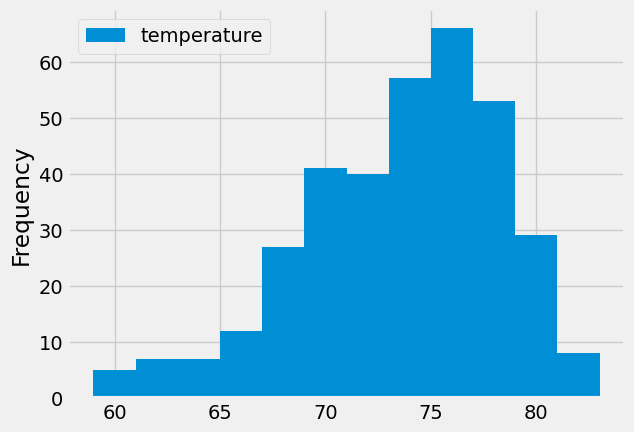

In [120]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_last_12 = session.query(Measurement.tobs).filter_by(station='USC00519281').filter(Measurement.date >= year_before).all()

# Create a pandas data frame from 'temp_last_12' to create a groupby count for each temperature
temp_last_12_df = pd.DataFrame(temp_last_12, columns=['temperature'])

# Plot Histogram
# Use Pandas Plotting with Matplotlib to plot the 'temp_last_12 data into histogram graph
temp_last_12_hist = temp_last_12_df.plot.hist(bins=12)
temp_last_12_hist;


# Close Session

In [166]:
# Close Session
session.close()

In [175]:
test_dt = '8-16-16'
dt.datetime.strptime(test_dt, '%m-%d-%y')

datetime.datetime(2016, 8, 16, 0, 0)